In [51]:
# load functions for data analysis
from scr_analysis_functions_fyp import experimental, visualizeStats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf    
import pandas, os, scipy
import seaborn as sns
import numpy as np

% pylab inline
pandas.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


In [52]:
data_path = '/Users/biota/Desktop/sSL/experiment_2/analysis/data_physio_study1'
day_one = experimental(data_path)
day_one.day = 1
day_one.preprocessData()

In [53]:
day_two = experimental(data_path)
day_two.day = 2
day_two.preprocessData()

In [54]:
cb = []
bc = []
for iSubject in range(0,len(day_two.subjectNames)): 
    if str.find(day_two.subjectNames[iSubject],'_cb_') != -1: 
        cb.append(iSubject)
    else: 
        bc.append(iSubject)

cb = np.array(cb)
bc = np.array(bc)

In [55]:

order = np.zeros(day_two.nSubjects)
order[cb] = 1


In [56]:
conditioning_pos_offsets = np.zeros([day_one.nSubjects,len(range(3,12))])
conditioning_neg_offsets = np.zeros([day_one.nSubjects,len(range(3,12))])

day_one.nSeconds = 4.5
conditioning = list(range(3,12))
for iStim in range(0,len(conditioning)):
    conditioning_pos_offsets[:,iStim], conditioning_neg_offsets[:,iStim] = day_one.amplitudeDifference('trans',
                                                                                                       conditioning[iStim],
                                                                                                       'offset');
conditioning_significance_offsets = np.zeros(day_one.nSubjects)
for iSubject in range(0,day_one.nSubjects): 
    conditioning_significance_offsets[iSubject] = scipy.stats.wilcoxon(conditioning_pos_offsets[iSubject,:],
                                                                     conditioning_neg_offsets[iSubject,:])[1];

In [57]:
start_con_onsets = 4
end_con_onsets   = 13
conditioning_pos_onsets = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])
conditioning_neg_onsets = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])

day_one.nSeconds = 4.5
conditioning = list(range(start_con_onsets,end_con_onsets))

for i_stim in range(0,len(conditioning)):
    conditioning_pos_onsets[:,i_stim], conditioning_neg_onsets[:,i_stim] = day_one.amplitudeDifference('trans',
                                                                           conditioning[i_stim],
                                                                           'onset');
conditioning_significance_onsets = np.zeros(day_one.nSubjects)

for i_subject in range(0,day_one.nSubjects): 
    conditioning_significance_onsets[i_subject] = scipy.stats.wilcoxon(conditioning_pos_onsets[i_subject,:],
                                                                 conditioning_neg_onsets[i_subject,:])[1];

In [58]:
log_conditioning_pos_onsets = log(1 + conditioning_pos_onsets)
log_conditioning_neg_onsets = log(1 + conditioning_neg_onsets)
log_renewal_plus = log(1 + renewal_plus)
log_renewal_minus = log(1 + renewal_minus)

log_learning = mean(log_conditioning_pos_onsets - log_conditioning_neg_onsets,1)
log_renewal =  log_renewal_plus - log_renewal_minus 

In [59]:

iStim = 0
day_two.nSeconds = 4.5
renewal_plus, renewal_minus = day_two.amplitudeDifference('trans',iStim,'onset');


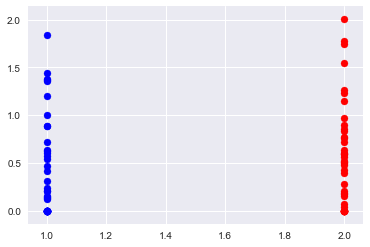

In [60]:
#scatter(order[cb], log_renewal_plus[cb])
scatter(np.ones(len(cb)), log_renewal_minus[order==True], color='blue')
scatter(np.ones(len(cb))+1, log_renewal_plus[order==True], color='red')

tmp_len = len(np.nonzero(order==False)[0])
scatter(np.ones(tmp_len), log_renewal_minus[order==False], color='blue')
scatter(np.ones(tmp_len)+1, log_renewal_plus[order==False], color='red')

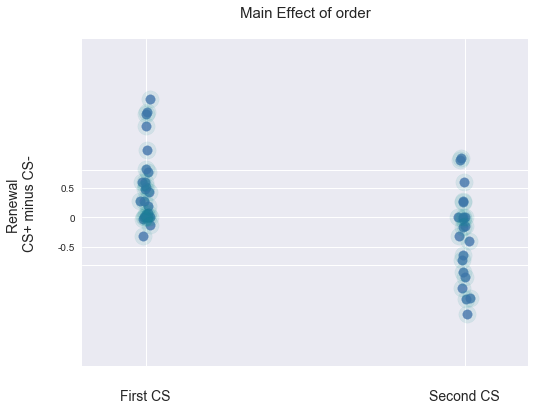

In [61]:

figure(figsize=[8,6])
jitter = np.random.randn(len(order))/100
scatter(order + jitter,log_renewal, alpha=.8, s=90)
scatter(order + jitter,log_renewal, color='darkcyan', alpha=.1, s=300)
ylabel('Renewal \nCS+ minus CS-\n', rotation=90, fontsize=14)
yticks([-.8, -.5,0,.5,.8],['', -.5,0,.5,''])
xticks([0, 1],['\nFirst CS','\nSecond CS'], fontsize=14)
xlim(-.2, 1.2)
ylim(-2.5, 3)
title('Main Effect of order\n', fontsize=15)


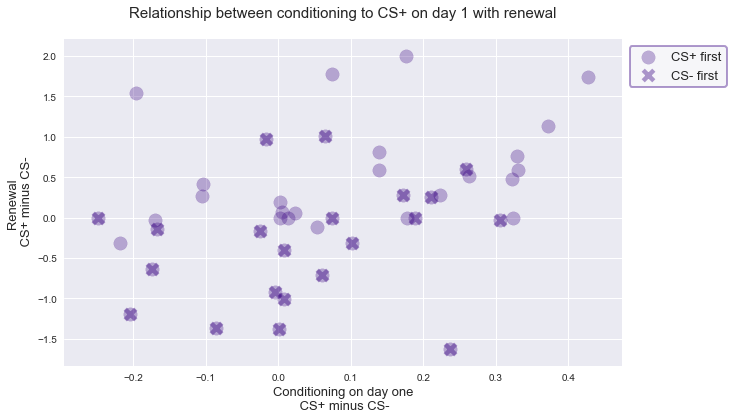

In [62]:
figure(figsize=(10,6))

scatter(log_learning, log_renewal,color='xkcd:indigo',alpha=.3,s=180, label='CS+ first')
scatter(log_learning[order==True], log_renewal[order==True],marker='x', color='xkcd:indigo',alpha=.4, s=10, linewidth=15, label='CS- first')

# control aesthetics
lgnd = legend(fontsize=13, fancybox=True, frameon=True, bbox_to_anchor=(.20, 1, 1, 0))
lgnd.get_frame().set_edgecolor('xkcd:indigo')
lgnd.get_frame().set_linewidth(2)
lgnd.get_frame().set_alpha(.4)

xlabel('Conditioning on day one\n CS+ minus CS-',fontsize=13)
ylabel('Renewal\n CS+ minus CS-',fontsize=13)
# yticks([0],[0])
# xticks([0],[0])
title('Relationship between conditioning to CS+ on day 1 with renewal\n',fontsize=15); 


In [63]:


SCR = pandas.DataFrame({'renewal':log_renewal, 'prediction':log_learning, 'order':order}) 



In [68]:
formula = 'renewal ~ prediction'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table

formula = 'renewal ~ prediction + C(order)'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
p_value = aov_table.values[2,3]
print '\n\n\t', formula, '\n\n', aov_table, '\n\n'



		renewal ~ prediction 

               sum_sq    df         F    PR(>F)
prediction   3.570007   1.0  5.948624  0.018931
Residual    25.806018  43.0       NaN       NaN


	renewal ~ prediction + C(order) 

               sum_sq    df          F    PR(>F)
C(order)     6.360503   1.0  13.737929  0.000609
prediction   1.769550   1.0   3.822016  0.057260
Residual    19.445515  42.0        NaN       NaN 




In [ ]:
# control for non-responders using raw data

In [22]:
start_con_onsets, end_con_onsets = 4, 13

conditioning_pos_onsets_raw = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])
conditioning_neg_onsets_raw = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])

day_one.nSeconds = 4.5
conditioning_inds = list(range(start_con_onsets, end_con_onsets))

for i_stim in range(0,len(conditioning_inds)):
    conditioning_pos_onsets_raw[:,i_stim], conditioning_neg_onsets_raw[:,i_stim] = day_one.amplitudeDifference('raw',
                                                                                   conditioning_inds[i_stim],
                                                                                   'onset');

In [29]:
day_two.nSeconds = 4.5
raw_renewal_plus, raw_renewal_minus = day_two.amplitudeDifference('raw',0,'onset');

In [35]:
# a = np.array([1,0,1,1,1,0])
# b = np.array([1,0,0,0,1,0])
# c = np.array([1,1,0,1,0,0])
# d = np.array([1,0,1,0,0,0])

# a & (b | d)

array([1, 0, 1, 0, 1, 0])

In [70]:

responders = np.array(mean(conditioning_pos_onsets_raw,1) > .02)


In [71]:
SCR = pandas.DataFrame({'renewal':log_renewal[responders], 
                        'prediction':log_learning[responders], 
                        'order':order[responders]})

In [82]:

formula = 'renewal ~ prediction'
model_prediction_responders = ols(formula, SCR).fit()
aov_table = anova_lm(model_prediction_responders, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table

formula = 'renewal ~ prediction + C(order)'
model_prediction_order_responders = ols(formula, SCR).fit()
aov_table_final = anova_lm(model_prediction_order_responders, typ=2)
p_value = aov_table_final.values[2,3]
print '\n\n\t', formula, '\n\n', aov_table_final, '\n\n'




		renewal ~ prediction 

               sum_sq    df          F    PR(>F)
prediction   7.144081   1.0  12.492717  0.001306
Residual    17.727650  31.0        NaN       NaN


	renewal ~ prediction + C(order) 

               sum_sq    df          F    PR(>F)
C(order)     6.379284   1.0  16.863970  0.000285
prediction   3.415634   1.0   9.029407  0.005324
Residual    11.348366  30.0        NaN       NaN 




In [78]:
p_value_responders_order_prediction = aov_table_final.values[1,3]

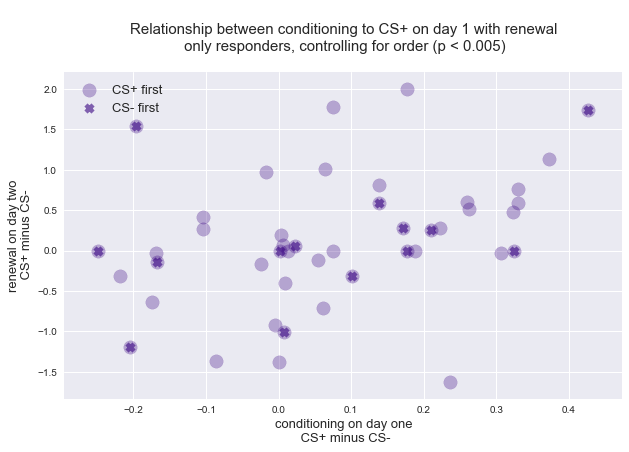

In [79]:
figure(figsize=(10,6))

iStim = 0
day_two.nSeconds = 4.5
renewal_plus, renewal_minus = day_two.amplitudeDifference('trans',iStim,'onset');

log_conditioning_pos_onsets = log(1 + conditioning_pos_onsets)
log_conditioning_neg_onsets = log(1 + conditioning_neg_onsets)
log_renewal_plus = log(1 + renewal_plus)
log_renewal_minus = log(1 + renewal_minus)

log_learning_responders = mean(log_conditioning_pos_onsets - log_conditioning_neg_onsets,1)[responders]
log_renewal_responders =  (log_renewal_plus - log_renewal_minus)[responders]
cb = np.nonzero(order[responders])[0]

scatter(log_learning, log_renewal,color='xkcd:indigo',alpha=.3,s=180, label='CS+ first')
scatter(log_learning[cb], log_renewal[cb],marker='x', color='xkcd:indigo',alpha=.6, s=10, linewidth=10, label='CS- first')

legend(loc=2, fontsize=13)
xlabel('conditioning on day one\n CS+ minus CS-',fontsize=13)
ylabel('renewal on day two\n CS+ minus CS-',fontsize=13)

title('\nRelationship between conditioning to CS+ on day 1 with renewal\n only responders, controlling for order (p < %.03f)\n' 
      %(p_value_responders_order_prediction), fontsize=15); 

In [ ]:
conditioning_significance_raw_onsets = np.zeros(day_one.nSubjects)

for i_subject in range(0,day_one.nSubjects): 
    conditioning_significance_raw_onsets[i_subject] = scipy.stats.ttest_ind(conditioning_pos_onsets_raw[i_subject,:],
                                                                 conditioning_neg_onsets_raw[i_subject,:])[1];

In [ ]:
conditioned_subjects_= find(conditioning_significance_onsets < .05)

In [ ]:
figure(figsize=[6,5])
#scatter(order[cb], log_renewal_plus[cb])
tmp_len_p = len(log_renewal_plus[conditioned_subjects_])
tmp_len_n = len(log_renewal_minus[conditioned_subjects_])
jitter_p = np.random.randn(tmp_len_p)/80
jitter_n = np.random.randn(tmp_len_n)/80

scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=100, alpha=.5,color='xkcd:red') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_],s=100, alpha=.5, color='xkcd:blue') 
xlim([-.1,.4])
ylim(-.2,.8)
xticks([0,.3], ['CS-', 'CS+'], fontsize=15); 

In [ ]:
# raw_conditioning_pos_onsets = np.zeros([day_one.nSubjects,len(range(3,12))])
# raw_conditioning_neg_onsets = np.zeros([day_one.nSubjects,len(range(3,12))])

# day_one.nSeconds = 5
# conditioning_indices = list(range(3,12))
# for iStim in range(0,len(conditioning_indices)):
#     raw_CSPs[:,iStim], raw_CSMs[:,iStim] = day1.amplitudeDifference('raw',conditioning[iStim],'onset');

In [ ]:
order = np.zeros(len(log_renewal)) ; order[cb] = 1 
scatter(order, log_renewal)

In [ ]:
pos

In [ ]:
def results_vary_p(conditioning_results, p_value): 
    
    conditioned_subjects = find(conditioning_results < p_value)
    
    iStim = 0
    day_two.nSeconds = 4.5
    plus, minus = day_two.amplitudeDifference('trans',iStim,'onset');

    pos_conditioned = log(1 + plus[conditioned_subjects])
    neg_conditioned = log(1 + minus[conditioned_subjects]) 

    _results_ = scipy.stats.ttest_ind(pos_conditioned, neg_conditioned)
    visualizeStats(pos_conditioned, neg_conditioned,_results_, 
                   heading='only testing for renewal in participants with significant (p < %s) conditioning on day one'
                   %p_value)

results_vary_p(conditioning_significance_onsets, .05) 

In [ ]:
responders = mean(raw_CSPs,1) > .01
# or 
# responders = np.array(raw_renewal_plus > .02) & np.array(raw_renewal_minus > .02)
# or 
# responders = np.array(raw_renewal_plus > .02) | np.array(raw_renewal_minus > .02)
# or 
#responders = np.array(mean(raw_CSPs,1) > .01) | np.array(raw_renewal_plus > .02) | np.array(raw_renewal_minus > .02)
# or 
# responders = np.array(mean(raw_CSPs,1) > .01) & np.array(raw_renewal_plus > .02) & np.array(raw_renewal_minus > .02)

In [ ]:
figure(figsize=(10,6))

iStim = 0
day2.nSeconds = 4.5
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
var1 = mean(CSP - CSM,1)#[conditionedSubjects]
var2 =  plus - minus #plus[conditionedSubjects]-minus[conditionedSubjects]

log_CSP = log(1 + CSP)
log_CSM = log(1 + CSM)
log_plus = log(1 + plus)
log_minus= log(1 + minus)
var1 = mean(log_CSP - log_CSM,1)
var2 =  log_plus - log_minus 
#var1 = var1[responders]
#var2 = var2[responders]

tmp = smf.OLS(var2,var1).fit()
scatter(var1,var2,color='xkcd:indigo',alpha=.3,s=50, label='subject data')
#scatter(var1[cb],var2[cb],color='xkcd:purple',s=50,alpha=.8,marker='x',label='counterbalanced subjects')

plot(var1, tmp.predict(var1) + mean(var1), color='xkcd:purple',linewidth=15,alpha=.1, label='linear fit')
legend(loc=4)
xlabel('anticipation\n CS+ minus CS-',fontsize=13)
ylabel('renewal\n CS+ minus CS-',fontsize=13)
title('Relationship between conditioning to CS+ on day 1 \n with renewal (p=%.3f) removing non-responders \n'
      %(tmp.pvalues),fontsize=15); 

In [ ]:
from scipy import stats

In [ ]:
figure(figsize=[12, 8])

var1 = mean(CSP - CSM,1)#[conditionedSubjects]
var2 =  plus - minus #plus[conditionedSubjects]-minus[conditionedSubjects]

responders = np.array(abs(plus) > .02) | np.array(abs(minus) > .02)

log_CSP = log(1 + CSP)
log_CSM = log(1 + CSM)
log_plus = log(1 + plus)
log_minus= log(1 + minus)
var1 = mean(log_CSP - log_CSM,1)#[conditionedSubjects]
var2 =  log_plus - log_minus #plus[conditionedSubjects]-minus[conditionedSubjects]

scatter(var1[responders], var2[responders], color='xkcd:indigo',alpha=.2, s=150, label='Day 2: CS+ First')

#scatter(var1[responders][cb], var2[responders][cb], marker='x', color='xkcd:indigo',alpha=.9, s=100, label='Day 2: CS- First')
use_lim = np.arange(min(var1), max(var1), .1)
edge_function = np.polyfit(var1, var2, 1)
function_ = np.poly1d(edge_function)
line_fit = function_(use_lim)
plot(use_lim, line_fit, alpha=.1, linewidth=15, color='xkcd:indigo')

leg = legend(fontsize=15, fancybox=True, frameon=True, bbox_to_anchor=(.269, 1, 1, 0))
leg.get_frame().set_edgecolor('xkcd:indigo')
leg.get_frame().set_linewidth(2)
leg.get_frame().set_alpha(.4)

xlabel('differential anticipatory response on day one\n (CS+ minus CS-)',fontsize=13)
ylabel('renewal\n CS+ minus CS-',fontsize=13)
title("\nRelationship between 'anticipation' of shock on day one with with renewal \n --controlling for order effects, removing non-responders: p < %.3f\n"% (tmp.pvalues),fontsize=16); 

# create a model removing non-responders! 

In [ ]:
# CREATE A DATA FRAME FOR PHYSIO removing non-responders

# response to first US
iStim = 4
#USplus, USminus = day1.amplitudeDifference('trans',iStim,'offset');
US = log(1 + USplus) - log(1 + USminus)
#US = USplus - USminus

# last stimulus from extinction
iStim = 21
plus_end, minus_end = day1.amplitudeDifference('trans',iStim,'onset');

# first stimulus on day 2
iStim = 0
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');

responders = np.array(abs(plus) > .02) | np.array(abs(minus) > .02)

# renewal on day 2
renewal = (log(1 + plus) - log(1 + minus)) #- (log(1 + plus_end) - log(1 + minus_end))

# difference across conditioning
difference = mean(log(1 + CSP) - log(1 + CSM),1) #difference = log(1 + difference)

# define non-responders as those who dont respond at all to the CS- on day two--better definition? 
#responders = abs(raw_renewal_minus) > .02
#responders = mean(raw_CSPs,1) > .01
#responders = np.array(raw_renewal_plus > .02) | np.array(raw_renewal_minus > .02)
#responders = np.array(mean(raw_CSPs,1) > .01) | np.array(raw_renewal_plus > .02) | np.array(raw_renewal_minus > .02)
# create data frame
SCR = pandas.DataFrame({'renewal':renewal[responders],
                        'prediction':difference[responders],
                        'US':US[responders],
                        'order':order[responders]})

In [ ]:
formula = 'renewal ~ prediction'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

In [ ]:
formula = 'renewal ~ US + prediction + C(order)'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
p_value = aov_table.values[2,3]
print(aov_table)

In [ ]:
print('\n\twe lost %s people who were non responders\n'%sum(responders == False)) 

# BOOM! SIGNIFICANCE CONTROLLING FOR ORDER!!?!! :::laughs::: 

# look at whether differential response on day one --> "renewal" to anything

In [ ]:
# CREATE A DATA FRAME FOR PHYSIO removing non-responders

# response to first US
iStim = 3

USplus, USminus = day1.amplitudeDifference('trans',iStim,'offset');
US = log(1 + USplus) - log(1 + USminus)
#US = USplus - USminus

# last stimulus from extinction
iStim = -1
plus_end, minus_end = day1.amplitudeDifference('trans',iStim,'onset');

# first stimulus on day 2
iStim = 0
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
responders = np.array(abs(plus) > .02) | np.array(abs(minus) > .02)

# renewal on day 2
renewal = (log(1 + plus) - log(1 + minus))# - (log(1 + plus_end) - log(1 + minus_end)))
#renewal =  abs((plus - minus)) - (plus_end - minus_end))


# difference across conditioning
difference = abs(mean(log(1 + CSP) - log(1 + CSM),1)) #difference = log(1 + difference)
#difference = (mean(CSP - CSM, 1)) #difference = log(1 + difference)

# create data frame
SCR = pandas.DataFrame({'renewal':renewal[responders],
                        'prediction':difference[responders],
                        'US':US[responders],
                        'order':order[responders]})

In [ ]:
formula = 'renewal ~ US + prediction + C(order)'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
p_value = aov_table.values[2,3]
print(aov_table)

In [ ]:
figure(figsize=[12, 6.5])

use_lim = np.arange(min(difference), max(difference), .1)
edge_function = np.polyfit(SCR['prediction'], SCR['renewal'], 1)
function_ = np.poly1d(edge_function)
line_fit = function_(use_lim)
#plot(use_lim, line_fit, alpha=.1, linewidth=15, color='xkcd:indigo')

scatter(order, renewal)
#scatter(difference[cb], renewal[cb], color='red')
title('order, not differential resopnse on day 1, explains renewal')

In [ ]:
# iStim = 0
# day2.nSeconds = 4.5

# plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
# var1 = mean(log(1 + CSP) - log(1 + CSM),1)
# var2 =  log(1 + plus) - log(1 + minus) 

# figure(figsize=[12, 6.5])

# cb_controlled = responders[cb]
# scatter(var1, var2, color='xkcd:indigo',alpha=.5, s=100, label='Day 2: CS+ First')

# scatter(var1[cb_controlled], var2[cb_controlled], marker='D', color='xkcd:indigo',alpha=.5, s=100, label='Day 2: CS- First')

# use_lim = np.arange(min(var1), max(var1), .1)
# edge_function = np.polyfit(var1, var2, 1)
# function_ = np.poly1d(edge_function)
# line_fit = function_(use_lim)
# plot(use_lim, line_fit, alpha=.1, linewidth=15, color='xkcd:indigo')

# leg = legend(fontsize=15, fancybox=True, frameon=True, loc=4) #bbox_to_anchor=(.2, 1, 1, 0))
# leg.get_frame().set_edgecolor('xkcd:indigo')
# leg.get_frame().set_linewidth(2)
# leg.get_frame().set_alpha(.4)

# xlabel('differential anticipatory response on day one\n (CS+ minus CS-)',fontsize=13)
# ylabel('renewal\n CS+ minus CS-',fontsize=13)
# title("\nRelationship between 'anticipation' of shock on day one with with renewal \n --controlling for order effects, removing non-responders: p < %.3f\n"% p_value,fontsize=16); 

In [ ]:
iStim = 0
day2.nSeconds = 4.5

plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
var1 = mean(log(1 + CSP[responders]) - log(1 + CSM[responders]),1)
var2 =  log(1 + plus[responders]) - log(1 + minus[responders]) 
#var1 = mean(CSP[responders] - CSM[responders], 1)
#var2 =  plus[responders] - minus[responders]

In [ ]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches([6,6])
ax = imshow(physio.corr())
ax1.set_xticks(np.array(list(range(0,len(physioTitleNames)))))
ax1.set_xticklabels(physioTitleNames,rotation=90,fontsize=10); 
ax1.set_yticks(np.array(list(range(0,len(physioTitleNames)))))
ax1.set_yticklabels(physioTitleNames,fontsize=10); 
ax.set_cmap('bwr') # 'coolwarm' # 'seismic'
ax.set_clim([-1,1])
ax.set_alpha(1)
title('\ncorrelation between physiological measurements\n corr(renewal,prediction) = %.2f\n'%
      (renewalPredictionCorr),fontsize=10); 

In [ ]:
import behavioral_analysis_functions_fyp as ba_fun
self_report, subject_names = ba_fun.generate_data_frame()
ba_fun.correlation_matrix(self_report)

In [ ]:
SCR.index = day2.subjectNames
count = 0
for isubject in range(0, len(SCR)):
    if self_report.index[count] in SCR.index[isubject]: 
        for ikey in self_report.keys():
            SCR.loc[SCR.index[isubject], ikey] =  self_report.loc[self_report.index[count], ikey]
        count = count + 1 
    else: 
        pass

In [ ]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches([10,10])
ax = plt.imshow(SCR.corr())
title_names = list(SCR.corr().keys())
ax1.set_xticks(np.array(list(range(0,len(title_names)))))
ax1.set_xticklabels(title_names,rotation=70);
ax1.set_yticks(np.array(list(range(0,len(title_names)))))
ax1.set_yticklabels(title_names);
ax.set_cmap('bwr') # 'coolwarm' # 'seismic'
ax.set_clim([-1,1])
ax.set_alpha(1)
plt.title('correlation between self report measures\n');
#plt.colorbar()
plt.show()

In [ ]:
# formula = 'renewal ~ prediction + correctColor'
# model = ols(formula, SCR).fit()
# aov_table = anova_lm(model, typ=2)
# print(aov_table)

In [ ]:
# 'US',
#  'order',
#  'prediction',
#  'renewal',
#  'post: relate',
#  'post: otherPain',
#  'post: color',
#  'pre: aversive',
#  'post: selfPain',
#  'post: familiar',
#  'post: like',
#  'post: similar',
#  'pre: voltage',
#  'color',
#  'belief',
#  'third',
#  'first',
#  'correctColor',
#  'expectShock'